# Exploratory notebook for miniblock decoding analysis
#### Plot decoding as a function of miniblock

In [1]:
import numpy as np
import scipy.stats as stats
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import pandas as pd
import loadTaskBehavioralData as task
import tools
import multiprocessing as mp
import statsmodels.stats.multitest as mc
%matplotlib inline

#### Parameter set up

In [125]:
projectdir = '/projects3/CPROCompositionality/'
datadir = projectdir + 'data/processedData/' 
resultdir = projectdir + 'data/results/'
subjNums = ['013','014','016','017','018','021','023','024','026','027','028',
            '030','031','032','033','034','035','037','038','039','040','041',
            '042','043','045','046','047','048','049','050','053','055','056',
            '057','058','062','063','066','067','068','069','070','072','074',
            '075','076','077','081','085','086','087','088','090','092','093',
            '094','095','097','098','099','101','102','103','104','105','106',
            '108','109','110','111','112','114','115','117','119','120','121',
            '122','123','124','125','126','127','128','129','130','131','132',
            '134','135','136','137','138','139','140','141']

glasser = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = nib.load(glasser).get_data()
glasser = np.squeeze(glasser)
rois = np.arange(1,361)

#### Load in CAB-NP ROI labels
cabn_labels = pd.read_csv(projectdir + 'data/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR_LabelKey.txt',header=0,delimiter='\t')
df_labels = cabn_labels.iloc[0:360]
df_labels.reset_index()
del df_labels['INDEX'], df_labels["KEYVALUE"]

# Using final partition
networkdef = df_labels['NETWORKKEY'].values
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}

fpn_ind = np.where(networkdef==networkmappings['fpn'])[0]
con_ind = np.where(networkdef==networkmappings['con'])[0]
ccn_ind = np.hstack((fpn_ind,con_ind))

In [187]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#### Load in logic rule PS, nov v prac

In [133]:
h5f = h5py.File(resultdir + 'ParallelismScoreTrialwise/LogicRules.h5','r')
ps_mat = h5f['data'][:]
h5f.close()
ps_pract_logic = np.zeros((360,len(subjNums)))
ps_novel_logic = np.zeros((360,len(subjNums)))
scount = 0
for subj in subjNums:
    df_subj = task.loadExperimentalData(subj)
    # Find which tasks are practiced for this subject
    tmpprac = df_subj.loc[df_subj.TaskNovelty=='Prac']
    unique_prac_id = np.unique(tmpprac.TaskID.values)-1.0
    unique_prac_id = unique_prac_id.astype(int)
    # Find which tasks are novel for this subject
    tmpnov = df_subj.loc[df_subj.TaskNovelty=='Novel']
    unique_nov_id = np.unique(tmpnov.TaskID.values)-1.0
    unique_nov_id = unique_nov_id.astype(int)
    
    ps_pract_logic[:,scount] = np.mean(ps_mat[:,unique_prac_id,scount],axis=1)
    ps_novel_logic[:,scount] = np.mean(ps_mat[:,unique_nov_id,scount],axis=1)
    
    scount += 1
        
ts, ps = stats.ttest_rel(ps_pract_logic,ps_novel_logic,axis=1)
i = 0
for t in ts:
    if t>0:
        ps[i] = ps[i]/2.0
    else:
        ps[i] = 1.0-ps[i]/2.0
    i += 1 
qs = mc.fdrcorrection(ps)[1]

print('Significant differences (after FDR)', np.where(qs[ccn_ind]<0.05)[0])
if len(np.where(qs[ccn_ind]<0.05)[0])>0:
    print('\t',networkdef[np.where(qs[ccn_ind]<0.05)[0]])
print('Significant differences (before FDR)', np.where(ps<0.05)[0])
if len(np.where(ps<0.05)[0])>0:
    print('\t',networkdef[np.where(ps<0.05)[0]])
        
data_logic = np.zeros((360,3))
data_logic[:,0] = np.mean(ps_pract_logic,axis=1)
data_logic[:,1] = np.mean(ps_novel_logic,axis=1)
data_logic[:,2] = np.mean(ps_pract_logic,axis=1)-np.mean(ps_novel_logic,axis=1)
tools.mapBackToSurface(data_logic,resultdir + 'ParallelismScoreTrialwise/LogicRule_NovelVPrac')

Significant differences (after FDR) []
Significant differences (before FDR) [ 63 277]
	 [9 7]


#### Plot whole-brain PS for Practiced V Novel for Logic Rule PS

t = -1.7705313891231693 | p = 0.0798463821701303


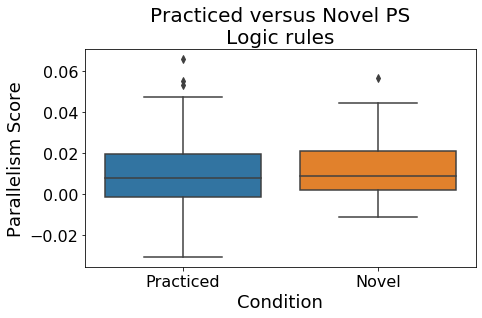

In [148]:
df = {}
df['PS'] = []
df['Condition'] = []
df['Subject'] = []
df['PS'].extend(np.mean(ps_pract_logic,axis=0))
df['Condition'].extend(np.repeat('Practiced',len(subjNums)))
df['Subject'].extend(subjNums)
df['PS'].extend(np.mean(ps_novel_logic,axis=0))
df['Condition'].extend(np.repeat('Novel',len(subjNums)))
df['Subject'].extend(subjNums)
df = pd.DataFrame(df)
plt.figure(figsize=(7,4))
sns.boxplot(data=df,y='PS',x='Condition')
plt.title('Practiced versus Novel PS\nLogic rules', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Parallelism Score',fontsize=18)
plt.xlabel('Condition',fontsize=18)
t, p = stats.ttest_rel(np.mean(ps_pract_logic,axis=0),np.mean(ps_novel_logic,axis=0))
print('t =', t, '| p =', p)

#### Load in sensory rule PS, nov v prac

In [134]:
h5f = h5py.File(resultdir + 'ParallelismScoreTrialwise/SensoryRules.h5','r')
ps_mat = h5f['data'][:]
h5f.close()
ps_pract_sensory = np.zeros((360,len(subjNums)))
ps_novel_sensory = np.zeros((360,len(subjNums)))
scount = 0
for subj in subjNums:
    df_subj = task.loadExperimentalData(subj)
    # Find which tasks are practiced for this subject
    tmpprac = df_subj.loc[df_subj.TaskNovelty=='Prac']
    unique_prac_id = np.unique(tmpprac.TaskID.values)-1.0
    unique_prac_id = unique_prac_id.astype(int)
    # Find which tasks are novel for this subject
    tmpnov = df_subj.loc[df_subj.TaskNovelty=='Novel']
    unique_nov_id = np.unique(tmpnov.TaskID.values)-1.0
    unique_nov_id = unique_nov_id.astype(int)
    
    ps_pract_sensory[:,scount] = np.mean(ps_mat[:,unique_prac_id,scount],axis=1)
    ps_novel_sensory[:,scount] = np.mean(ps_mat[:,unique_nov_id,scount],axis=1)
    
    scount += 1
        
ts, ps = stats.ttest_rel(ps_pract_sensory,ps_novel_sensory,axis=1)
i = 0
for t in ts:
    if t>0:
        ps[i] = ps[i]/2.0
    else:
        ps[i] = 1.0-ps[i]/2.0
    i += 1 
qs = mc.fdrcorrection(ps)[1]

print('Significant differences (after FDR)', np.where(qs<0.05)[0])
if len(np.where(qs<0.05)[0])>0:
    print('\t',networkdef[np.where(qs<0.05)[0]])
print('Significant differences (before FDR)', np.where(ps<0.05)[0])
if len(np.where(ps<0.05)[0])>0:
    print('\t',networkdef[np.where(ps<0.05)[0]])
        
data_sensory = np.zeros((360,3))
data_sensory[:,0] = np.mean(ps_pract_sensory,axis=1)
data_sensory[:,1] = np.mean(ps_novel_sensory,axis=1)
data_sensory[:,2] = np.mean(ps_pract_sensory,axis=1)-np.mean(ps_novel_sensory,axis=1)
tools.mapBackToSurface(data_sensory,resultdir + 'ParallelismScoreTrialwise/SensoryRule_NovelVPrac')

Significant differences (after FDR) []
Significant differences (before FDR) [155]
	 [2]


#### Plot whole-brain PS for Practiced V Novel for Sensory Rule PS

t = -1.5566808565589494 | p = 0.12287154245358954


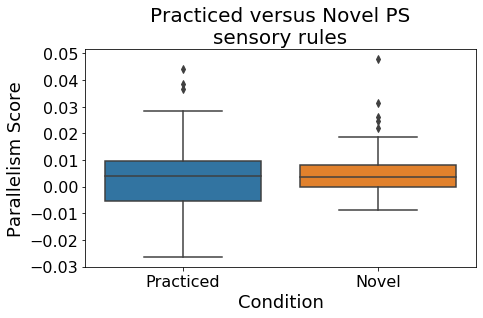

In [149]:
df = {}
df['PS'] = []
df['Condition'] = []
df['Subject'] = []
df['PS'].extend(np.mean(ps_pract_sensory,axis=0))
df['Condition'].extend(np.repeat('Practiced',len(subjNums)))
df['Subject'].extend(subjNums)
df['PS'].extend(np.mean(ps_novel_sensory,axis=0))
df['Condition'].extend(np.repeat('Novel',len(subjNums)))
df['Subject'].extend(subjNums)
df = pd.DataFrame(df)
plt.figure(figsize=(7,4))
sns.boxplot(data=df,y='PS',x='Condition')
plt.title('Practiced versus Novel PS\nsensory rules', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Parallelism Score',fontsize=18)
plt.xlabel('Condition',fontsize=18)
t, p = stats.ttest_rel(np.mean(ps_pract_sensory,axis=0),np.mean(ps_novel_sensory,axis=0))
print('t =', t, '| p =', p)

#### Load in motor rule PS, nov v prac

In [135]:
h5f = h5py.File(resultdir + 'ParallelismScoreTrialwise/MotorRules.h5','r')
ps_mat = h5f['data'][:]
h5f.close()
ps_pract_motor = np.zeros((360,len(subjNums)))
ps_novel_motor = np.zeros((360,len(subjNums)))
scount = 0
for subj in subjNums:
    df_subj = task.loadExperimentalData(subj)
    # Find which tasks are practiced for this subject
    tmpprac = df_subj.loc[df_subj.TaskNovelty=='Prac']
    unique_prac_id = np.unique(tmpprac.TaskID.values)-1.0
    unique_prac_id = unique_prac_id.astype(int)
    # Find which tasks are novel for this subject
    tmpnov = df_subj.loc[df_subj.TaskNovelty=='Novel']
    unique_nov_id = np.unique(tmpnov.TaskID.values)-1.0
    unique_nov_id = unique_nov_id.astype(int)
    
    ps_pract_motor[:,scount] = np.mean(ps_mat[:,unique_prac_id,scount],axis=1)
    ps_novel_motor[:,scount] = np.mean(ps_mat[:,unique_nov_id,scount],axis=1)
    
    scount += 1
        
ts, ps = stats.ttest_rel(ps_pract_motor,ps_novel_motor,axis=1)
i = 0
for t in ts:
    if t>0:
        ps[i] = ps[i]/2.0
    else:
        ps[i] = 1.0-ps[i]/2.0
    i += 1 
qs = mc.fdrcorrection(ps)[1]

print('Significant differences (after FDR)', np.where(qs<0.05)[0])
if len(np.where(qs<0.05)[0])>0:
    print('\t',networkdef[np.where(qs<0.05)[0]])
print('Significant differences (before FDR)', np.where(ps<0.05)[0])
if len(np.where(ps<0.05)[0])>0:
    print('\t',networkdef[np.where(ps<0.05)[0]])
        
data_motor = np.zeros((360,3))
data_motor[:,0] = np.mean(ps_pract_motor,axis=1)
data_motor[:,1] = np.mean(ps_novel_motor,axis=1)
data_motor[:,2] = np.mean(ps_pract_motor,axis=1)-np.mean(ps_novel_motor,axis=1)
tools.mapBackToSurface(data_motor,resultdir + 'ParallelismScoreTrialwise/MotorRule_NovelVPrac')

Significant differences (after FDR) []
Significant differences (before FDR) [165 255]
	 [12  9]


#### Plot whole-brain PS for Practiced V Novel for Motor Rule PS

t = -1.7647315537360886 | p = 0.08082277548134403


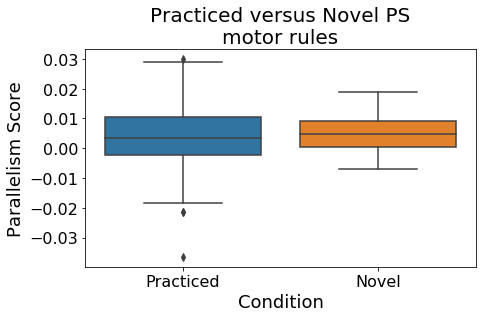

In [150]:
df = {}
df['PS'] = []
df['Condition'] = []
df['Subject'] = []
df['PS'].extend(np.mean(ps_pract_motor,axis=0))
df['Condition'].extend(np.repeat('Practiced',len(subjNums)))
df['Subject'].extend(subjNums)
df['PS'].extend(np.mean(ps_novel_motor,axis=0))
df['Condition'].extend(np.repeat('Novel',len(subjNums)))
df['Subject'].extend(subjNums)
df = pd.DataFrame(df)
plt.figure(figsize=(7,4))
sns.boxplot(data=df,y='PS',x='Condition')
plt.title('Practiced versus Novel PS\nmotor rules', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Parallelism Score',fontsize=18)
plt.xlabel('Condition',fontsize=18)
t, p = stats.ttest_rel(np.mean(ps_pract_motor,axis=0),np.mean(ps_novel_motor,axis=0))
print('t =', t, '| p =', p)

# Combination of logic, sensory, and motor differences in PS

In [142]:
prac_combo = ps_pract_logic + ps_pract_sensory + ps_pract_motor
novel_combo = ps_novel_logic + ps_novel_sensory + ps_novel_motor

t, p = stats.ttest_rel(prac_combo,novel_combo,axis=1)
# i = 0
# for t in ts:
#     if t>0:
#         ps[i] = ps[i]/2.0
#     else:
#         ps[i] = 1.0-ps[i]/2.0
#     i += 1 
qs = mc.fdrcorrection(ps)[1]

print('Significant differences (after FDR)', np.where(qs<0.05)[0])
if len(np.where(qs<0.05)[0])>0:
    print('\t',networkdef[np.where(qs<0.05)[0]])
print('Significant differences (before FDR)', np.where(ps<0.05)[0])
if len(np.where(ps<0.05)[0])>0:
    print('\t',networkdef[np.where(ps<0.05)[0]])
    
data_combo = np.zeros((360,3))
data_combo[:,0] = np.mean(prac_combo,axis=1)
data_combo[:,1] = np.mean(novel_combo,axis=1)
data_combo[:,2] = np.mean(prac_combo,axis=1)-np.mean(novel_combo,axis=1)
tools.mapBackToSurface(data_combo,resultdir + 'ParallelismScoreTrialwise/3RuleCombo_NovelVPrac')

Significant differences (after FDR) []
Significant differences (before FDR) [ 15  19 145 158 165 255]
	 [ 2  2  5  2 12  9]


#### Plot whole-brain PS for Practiced V Novel for all 3 rules PS

t = -3.189576038453279 | p = 0.0019305967152210808


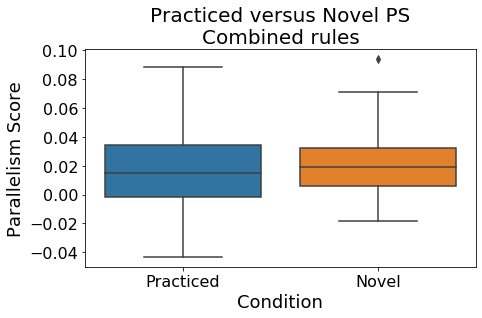

In [151]:
df = {}
df['PS'] = []
df['Condition'] = []
df['Subject'] = []
df['PS'].extend(np.mean(prac_combo,axis=0))
df['Condition'].extend(np.repeat('Practiced',len(subjNums)))
df['Subject'].extend(subjNums)
df['PS'].extend(np.mean(novel_combo,axis=0))
df['Condition'].extend(np.repeat('Novel',len(subjNums)))
df['Subject'].extend(subjNums)
df = pd.DataFrame(df)
plt.figure(figsize=(7,4))
sns.boxplot(data=df,y='PS',x='Condition')
plt.title('Practiced versus Novel PS\nCombined rules', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Parallelism Score',fontsize=18)
plt.xlabel('Condition',fontsize=18)
t, p = stats.ttest_rel(np.mean(prac_combo,axis=0),np.mean(novel_combo,axis=0))
print('t =', t, '| p =', p)

# Negation PS scores

In [118]:
h5f = h5py.File(resultdir + 'ParallelismScoreTrialwise/LogicRules.h5','r')
ps_mat = h5f['data'][:]
h5f.close()
ps_pos = np.zeros((360,len(subjNums)))
ps_neg = np.zeros((360,len(subjNums)))
scount = 0
for subj in subjNums:
    df_subj = task.loadExperimentalData(subj)
    # Find which tasks are negations for this subject
    df_both = df_subj.loc[df_subj.LogicRules=='**BOTH**']
    unique_both_id = np.unique(df_both.TaskID.values)-1.0
    df_either = df_subj.loc[df_subj.LogicRules=='*EITHER*']
    unique_either_id = np.unique(df_either.TaskID.values)-1.0
    affirmative_ind = np.hstack((unique_both_id,unique_either_id))
    
    # Find which tasks are negations for this subject
    df_nboth = df_subj.loc[df_subj.LogicRules=='NOT*BOTH']
    unique_nboth_id = np.unique(df_nboth.TaskID.values)-1.0
    df_neither = df_subj.loc[df_subj.LogicRules=='NEITHER*']
    unique_neither_id = np.unique(df_neither.TaskID.values)-1.0
    negation_ind = np.hstack((unique_nboth_id,unique_neither_id))
    
    negation_ind = negation_ind.astype(int)
    affirmative_ind = affirmative_ind.astype(int)
    ps_pos[:,scount] = np.mean(ps_mat[:,affirmative_ind,scount],axis=1)
    ps_neg[:,scount] = np.mean(ps_mat[:,negation_ind,scount],axis=1)
    
    scount += 1
        
        
ts, ps = stats.ttest_rel(ps_pos,ps_neg,axis=1)
i = 0
for t in ts:
    if t>0:
        ps[i] = ps[i]/2.0
    else:
        ps[i] = 1.0-ps[i]/2.0
    i += 1 
qs = mc.fdrcorrection(ps)[1]

print('Significant differences (after FDR)', np.where(qs<0.05)[0])
if len(np.where(qs<0.05)[0])>0:
    print('\t',networkdef[np.where(qs<0.05)[0]])
print('Significant differences (before FDR)', np.where(ps<0.05)[0])
if len(np.where(ps<0.05)[0])>0:
    print('\t',networkdef[np.where(ps<0.05)[0]])
data = np.zeros((360,3))
data[:,0] = np.mean(ps_pos,axis=1)
data[:,1] = np.mean(ps_neg,axis=1)
data[:,2] = np.mean(ps_pos,axis=1)-np.mean(ps_neg,axis=1)
tools.mapBackToSurface(data,resultdir + 'ParallelismScoreTrialwise/LogicRuleNegation')

Significant differences (after FDR) []
Significant differences (before FDR) [ 93 128 255 358]
	 [9 6 9 4]


#### Plot whole-brain PS for Affirmative v Negation (logic rule) PS

t = -1.6198758017355737 | p = 0.1085739556352574


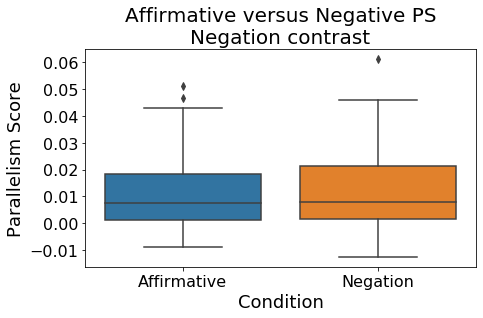

In [152]:
df = {}
df['PS'] = []
df['Condition'] = []
df['Subject'] = []
df['PS'].extend(np.mean(ps_pos,axis=0))
df['Condition'].extend(np.repeat('Affirmative',len(subjNums)))
df['Subject'].extend(subjNums)
df['PS'].extend(np.mean(ps_neg,axis=0))
df['Condition'].extend(np.repeat('Negation',len(subjNums)))
df['Subject'].extend(subjNums)
df = pd.DataFrame(df)
plt.figure(figsize=(7,4))
sns.boxplot(data=df,y='PS',x='Condition')
plt.title('Affirmative versus Negative PS\nNegation contrast', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Parallelism Score',fontsize=18)
plt.xlabel('Condition',fontsize=18)
t, p = stats.ttest_rel(np.mean(ps_pos,axis=0),np.mean(ps_neg,axis=0))
print('t =', t, '| p =', p)